In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
warnings.filterwarnings('ignore')

# General functions for data visualization.

In [3]:
def visualize_boxplot(plot_x):
    fig, ax = plt.subplots(2, 2, figsize = (20, 8))
    col_lst = ['gdpp', 'child_mort', 'income']
    col_dict = {'gdpp' : 'GDP per capita', 'child_mort' : 'under 5 child deaths/1k', 'income' : 'net income per person'}


    for i,j in enumerate(range(0, len(col_lst), 2)):
        sns.boxplot(x = plot_x, y = col_lst[j], data = ctr_df, ax = ax[i, 0])
        ax[i, 0].set_title('Cluster wise distribution of ' + col_dict[col_lst[j]], fontsize = 20)
        ax[i, 0].set_xlabel('', fontsize = 15)
        ax[i, 0].set_ylabel(col_dict[col_lst[j]], fontsize = 15)
    
        if j + 1 >= len(col_lst):
            ax[-1, -1].axis('off')
            break

        sns.boxplot(x = plot_x, y = col_lst[j + 1], data = ctr_df, ax = ax[i, 1])
        ax[i, 1].set_title('Cluster wise distribution of ' + col_dict[col_lst[j + 1]], fontsize = 20)
        ax[i, 1].set_xlabel('', fontsize = 15)
        ax[i, 1].set_ylabel(col_dict[col_lst[j + 1]], fontsize = 15)
    

    plt.show()

In [4]:
def visualize_scatter(plot_hue):
    fig, ax = plt.subplots(3, 1, figsize = (15, 18))
    
    sns.scatterplot(x = 'gdpp', y = 'child_mort', hue = plot_hue, data = ctr_df, s = 100, ax = ax[0])
    sns.scatterplot(x = 'gdpp', y = 'income', hue = plot_hue, data = ctr_df, s = 100, ax = ax[1])
    sns.scatterplot(y = 'child_mort', x = 'income', hue = plot_hue, data = ctr_df, s = 100, ax = ax[2])
    
    ax[0].set_title('Per person income vs per capita GDP', fontsize = 20)
    ax[0].set_xlabel('Per capita GDP', fontsize = 15)
    ax[0].set_ylabel('Per person income', fontsize = 15)

    ax[1].set_title('Child Deaths/1k vs per person income', fontsize = 20)
    ax[1].set_xlabel('Per person income', fontsize = 15)
    ax[1].set_ylabel('Child deaths/1k', fontsize = 15)

    ax[2].set_title('Child Deaths/1k vs per capita GDP', fontsize = 20)
    ax[2].set_xlabel('Per capita GDP', fontsize = 15)
    ax[2].set_ylabel('Child deaths/1k', fontsize = 15)
    
    plt.show()

# Reading the dataframe and initial inspection.

In [5]:
ctr_df = pd.read_csv('Country-data.csv')
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Calculating actual exports, health and imports values from gdpp.

In [6]:
ctr_df['exports'] = ctr_df['exports'] * ctr_df['gdpp'] / 100
ctr_df['health'] = ctr_df['health'] * ctr_df['gdpp'] / 100
ctr_df['imports'] = ctr_df['imports'] * ctr_df['gdpp'] / 100

ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [7]:
ctr_df.shape

(167, 10)

### There are 167 countries.

In [8]:
def highlight_outliers(data):
    attr = 'background-color: {}'.format('yellow')
    df_mask = pd.DataFrame('', index = data.index, columns = data.columns)
    
    out_lst = ['96%', '97%', '95%', '96%', '94%', '98%', '2%', '99%', '97%']

    for ind in range(len(out_lst)):
        df_mask.loc[out_lst[ind]][ind] = attr
    
    return df_mask

In [9]:
desc_df = ctr_df.describe(percentiles = [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, \
                                         0.97, 0.98, 0.99])
desc_df.style.apply(highlight_outliers, axis = None)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
1%,2.800000,22.243716,17.009362,104.909640,742.240000,-2.348800,47.160000,1.243200,331.620000
2%,3.000000,53.483040,18.438976,124.418800,837.680000,-1.288240,52.352000,1.282800,364.320000
5%,3.460000,70.468800,26.715920,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
10%,4.200000,110.224800,36.502560,211.005600,1524.000000,0.587800,57.820000,1.452000,593.800000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000


### We can see that there are outliers in our dataset, based on the percentile values. The highlighted cells indicate the values after where the outliers begin, except for life_expec where the outliers are closer towards second percentile.

In [10]:
ctr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


### No missing values are present.

# Univariate Analysis

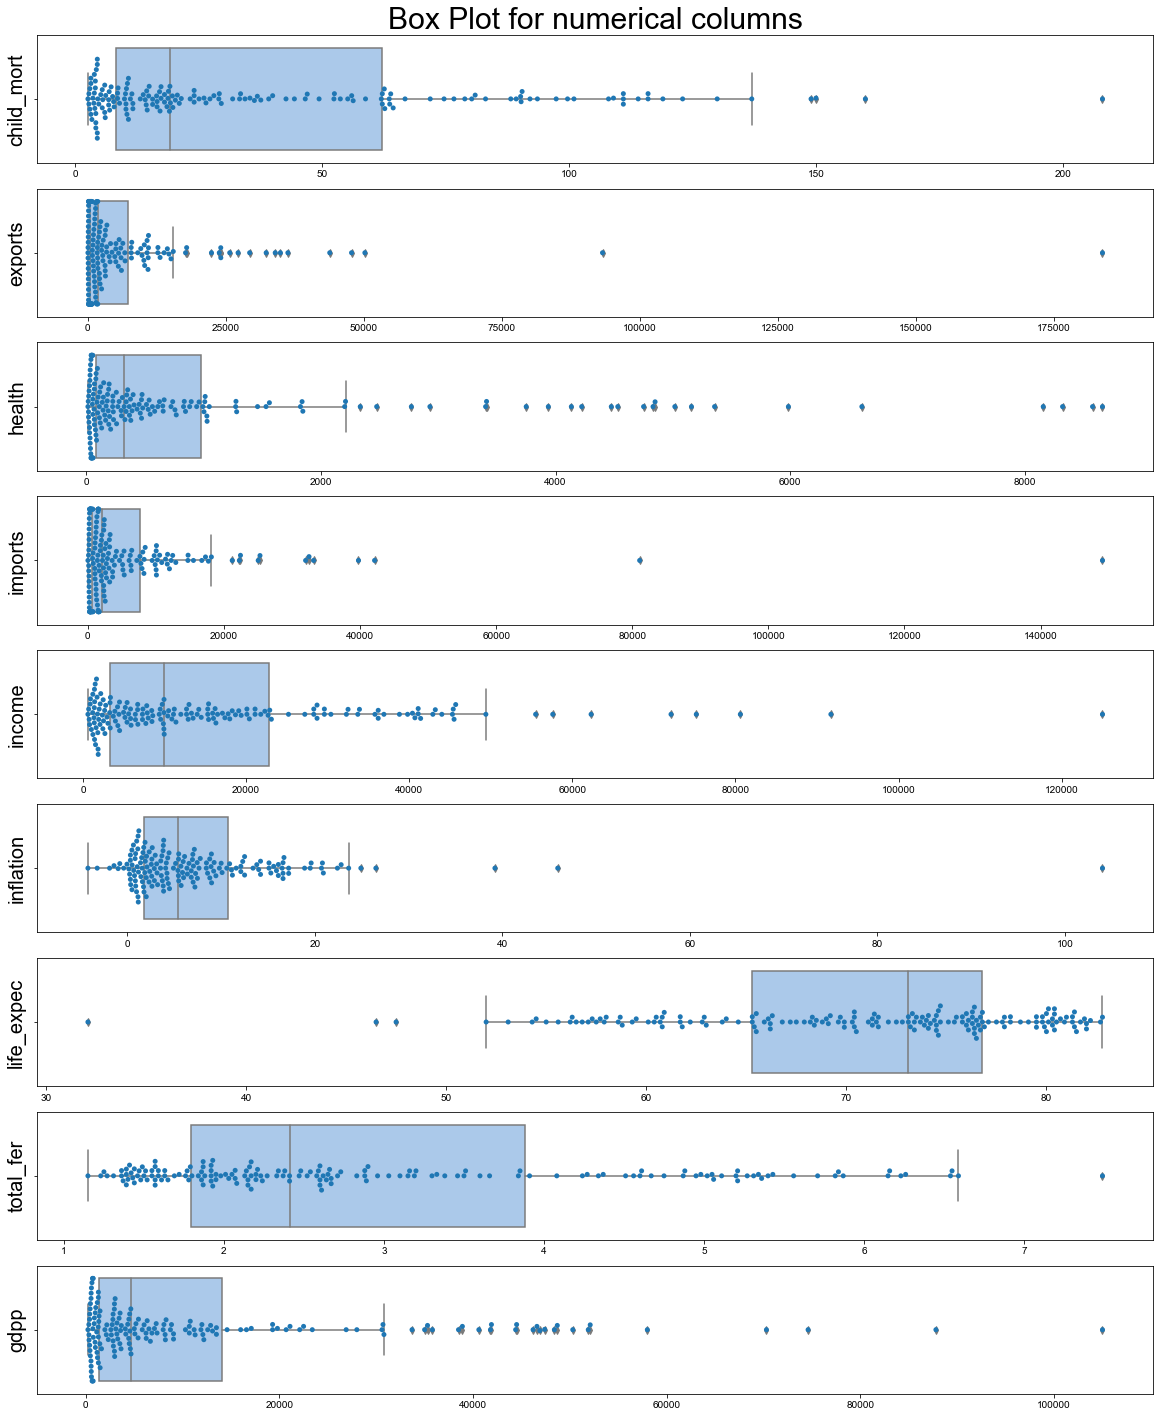

In [11]:
fig, ax = plt.subplots(9, 1, figsize = (20, 25))
i = 0
sns.set_style("darkgrid")
num_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for col in num_cols:
    sns.boxplot(x = col, data = ctr_df, ax = ax[i], palette = 'pastel')
    sns.swarmplot(x = col, data = ctr_df, ax = ax[i])
    ax[i].set_ylabel(col, fontsize = 20)
    ax[i].set_xlabel('')
    i += 1

ax[0].set_title('Box Plot for numerical columns', fontsize = 30)
plt.show()

### Let us cap the outliers belonging to 'rich/developed' countries as we want to focus more on poor countries.

In [12]:
cap_val = ctr_df.exports.quantile([0.97])[0.97]
ctr_df['exports'] = ctr_df['exports'].apply(lambda x: cap_val if x > cap_val else x)

cap_val = ctr_df.health.quantile([0.95])[0.95]
ctr_df['health'] = ctr_df['health'].apply(lambda x: cap_val if x > cap_val else x)

cap_val = ctr_df.imports.quantile([0.96])[0.96]
ctr_df['imports'] = ctr_df['imports'].apply(lambda x: cap_val if x > cap_val else x)

cap_val = ctr_df.income.quantile([0.94])[0.94]
ctr_df['income'] = ctr_df['income'].apply(lambda x: cap_val if x > cap_val else x)

cap_val = ctr_df.gdpp.quantile([0.97])[0.97]
ctr_df['gdpp'] = ctr_df['gdpp'].apply(lambda x: cap_val if x > cap_val else x)

## Visualizing the boxplots again.

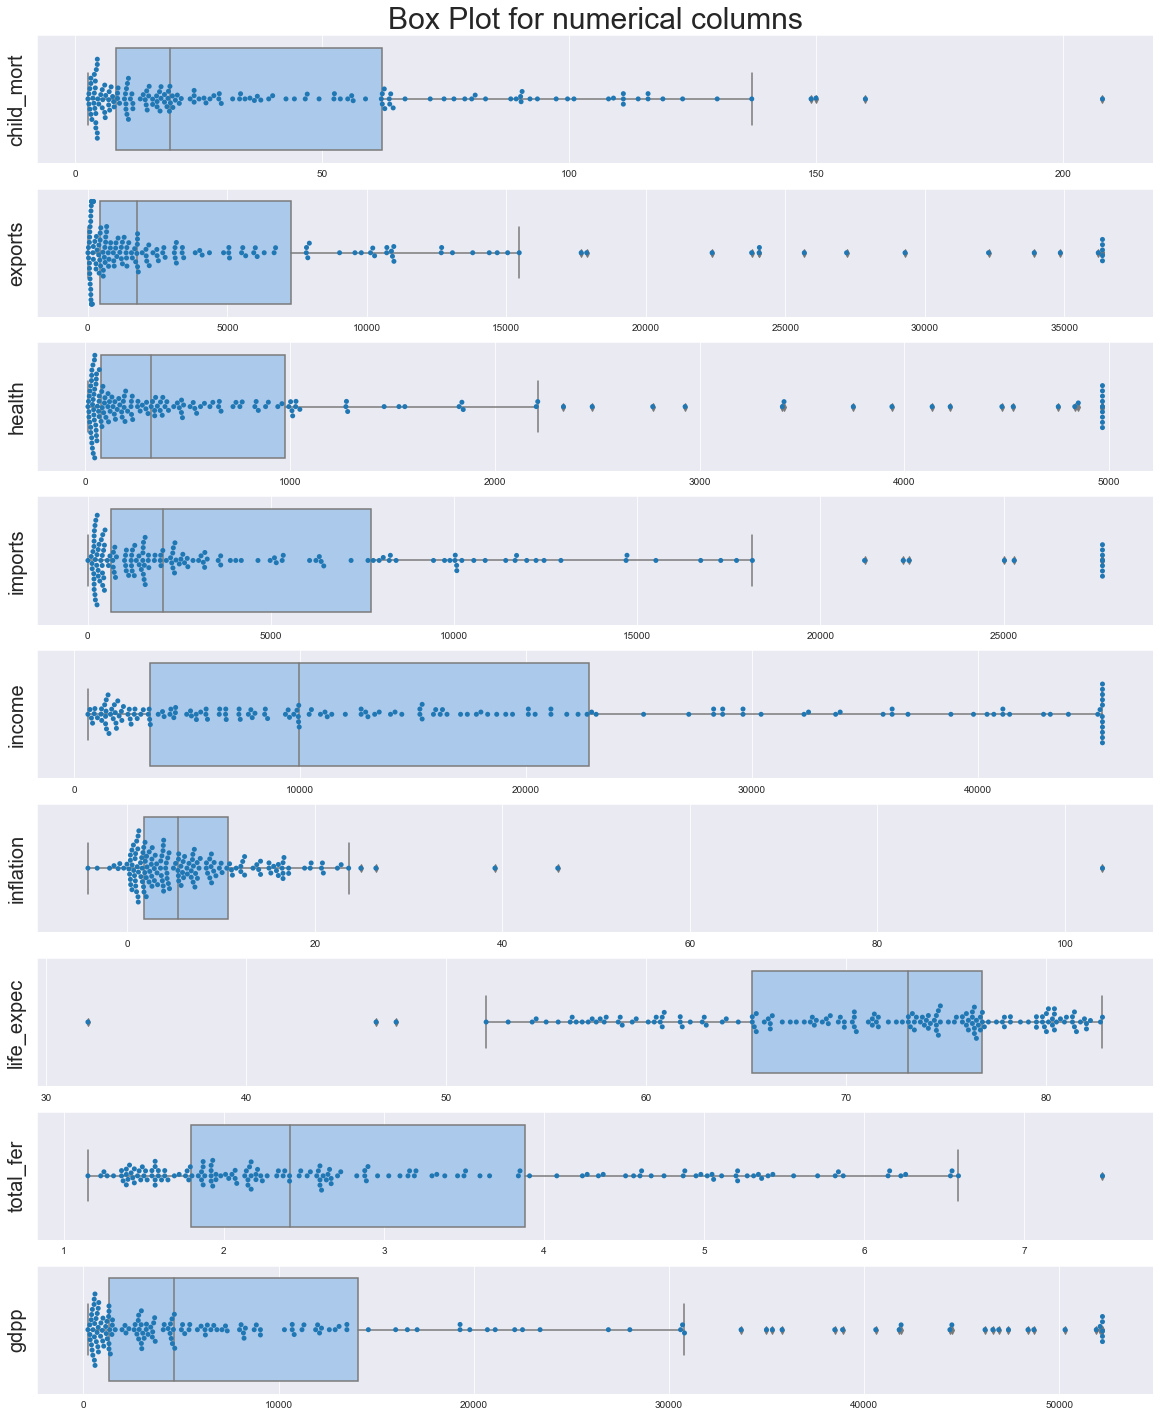

In [13]:
fig, ax = plt.subplots(9, 1, figsize = (20, 25))
i = 0
sns.set_style("darkgrid")
num_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for col in num_cols:
    sns.boxplot(x = col, data = ctr_df, ax = ax[i], palette = 'pastel')
    sns.swarmplot(x = col, data = ctr_df, ax = ax[i])
    ax[i].set_ylabel(col, fontsize = 20)
    ax[i].set_xlabel('')
    i += 1

ax[0].set_title('Box Plot for numerical columns', fontsize = 30)
plt.show()

### No significant outliers present.

# Bivariate Analysis

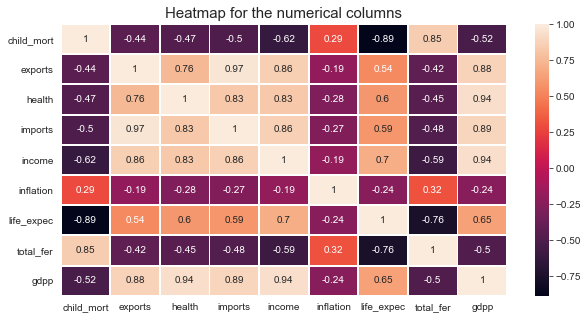

In [14]:
plt.figure(figsize = (10, 5))
plt.title('Heatmap for the numerical columns', fontsize = 15)
corr_df = ctr_df.corr()
sns.heatmap(corr_df, annot = True, linewidth = 0.9, linecolor = 'white')
plt.show()

### From the above heatmap, we can deduce the following points.
    - Life Expectancy is highly negatively correlated with Child Mortality and Total Fertility.
    - Life Expectancy and Health, Income and GDP are highly positively correlated.
    - Exports is positively correlated with Health, Imports, Income and GDP.

# Scaling the data

In [15]:
scaler = MinMaxScaler()

num_df = pd.DataFrame(scaler.fit_transform(ctr_df[num_cols]), columns = num_cols)
num_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.001491,0.005873,0.008940,0.022294,0.126144,0.475345,0.736593,0.006194
1,0.068160,0.031461,0.051490,0.071735,0.207599,0.080399,0.871795,0.078864,0.074230
2,0.120253,0.047064,0.034955,0.050533,0.273748,0.187691,0.875740,0.274448,0.081347
3,0.566699,0.060443,0.017720,0.054646,0.117842,0.245911,0.552268,0.790221,0.063458
4,0.037488,0.152611,0.145914,0.259388,0.411835,0.052213,0.881657,0.154574,0.230231


# Hopkins Test

In [16]:
def hopkins_stat(X):
    nbrs = NearestNeighbors(n_neighbors = 1).fit(X.values)
    m = int(0.1 * len(X))
    rand_X = sample(range(0, len(X), 1), m)
    
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis = 0), np.amax(X, axis = 0), X.shape[1]).reshape(1, -1), \
                                   2, return_distance = True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance = True)
        wjd.append(w_dist[0][1])
    
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return H

In [17]:
print('Hopkins statistic:', hopkins_stat(num_df))

Hopkins statistic: 0.8967870639881714


### The value is close to 1 means that there is a clustering tendency in the data.

# Clustering using KMeans

In [18]:
num_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
ssd = []
for cluster in num_clusters:
    k_cluster = KMeans(n_clusters = cluster, max_iter = 50, random_state = 100)
    k_cluster.fit(num_df)
    ssd.append(k_cluster.inertia_)
    s_score = silhouette_score(num_df, k_cluster.labels_)
    print('Number of Clusters: {0}    Silhoutte Score: {1}    SSD: {2}'.format(cluster, round(s_score, 3), k_cluster.inertia_))

Number of Clusters: 2    Silhoutte Score: 0.578    SSD: 36.59567263815072
Number of Clusters: 3    Silhoutte Score: 0.453    SSD: 23.874799433121165
Number of Clusters: 4    Silhoutte Score: 0.444    SSD: 17.67220085940678
Number of Clusters: 5    Silhoutte Score: 0.429    SSD: 14.848624635397965
Number of Clusters: 6    Silhoutte Score: 0.35    SSD: 12.497707931122488
Number of Clusters: 7    Silhoutte Score: 0.368    SSD: 10.944097643964039
Number of Clusters: 8    Silhoutte Score: 0.316    SSD: 9.891297835094601
Number of Clusters: 9    Silhoutte Score: 0.317    SSD: 9.029795459154277


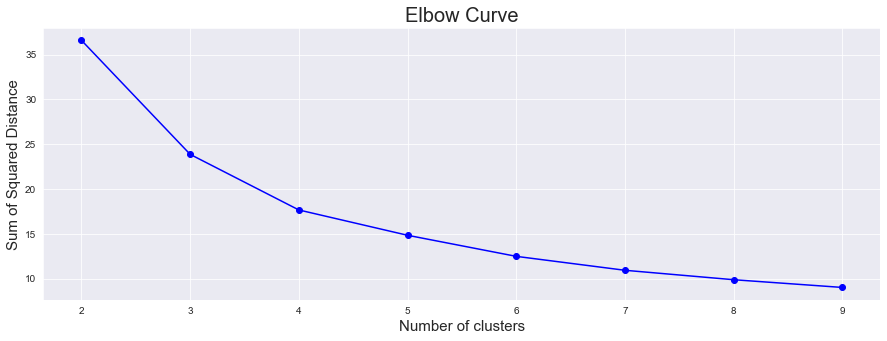

In [19]:
plt.figure(figsize = (15, 5))
plt.title('Elbow Curve', fontsize = 20)
plt.plot(num_clusters, ssd, 'o-', color = 'blue')
plt.xlabel('Number of clusters', fontsize = 15)
plt.ylabel('Sum of Squared Distance', fontsize = 15)
plt.show()

### Using both the elbow curve and Silhouette score, we can finalize the number of clusters as 3.

In [20]:
# Finalizing k = 3
kmeans_3 = KMeans(n_clusters = 3, max_iter = 50, random_state = 100)
kmeans_3.fit(num_df)

ctr_df['kmeans_labels'] = kmeans_3.labels_
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


## Visualizing clusters formed

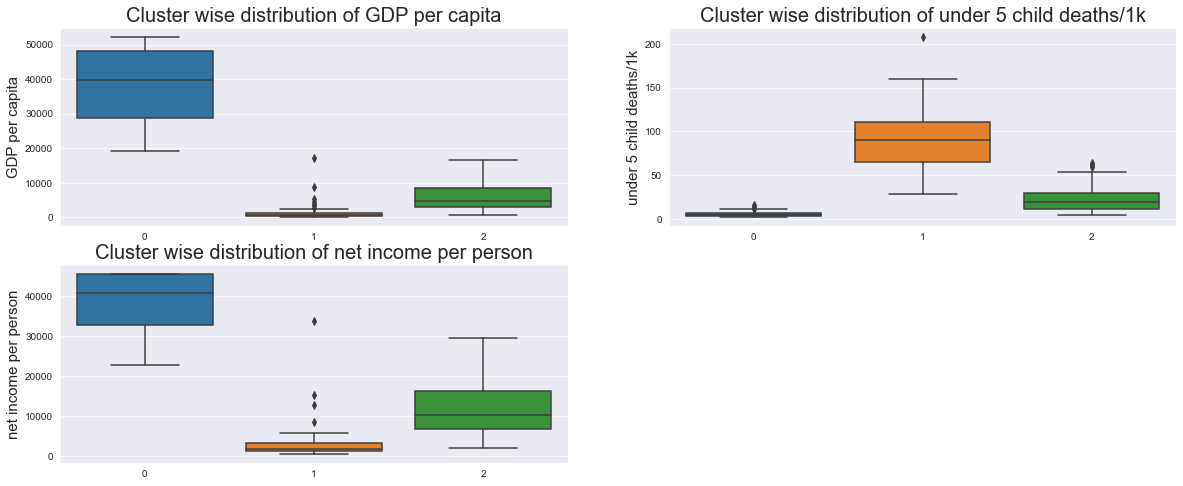

In [21]:
visualize_boxplot('kmeans_labels')

### From the above box plots, we can conclude the following
 - There are 3 distinct clusters present in our data.
 - Countries belonging to cluster 2 are weak, they have a low net income per person, high child deaths/1k, low GDP per capita and low average life of newborns.
 - Countries belonging to cluster 0 are strong, a high net income per person, low child deaths/1k, high GDP per capita and high average life of newborns.

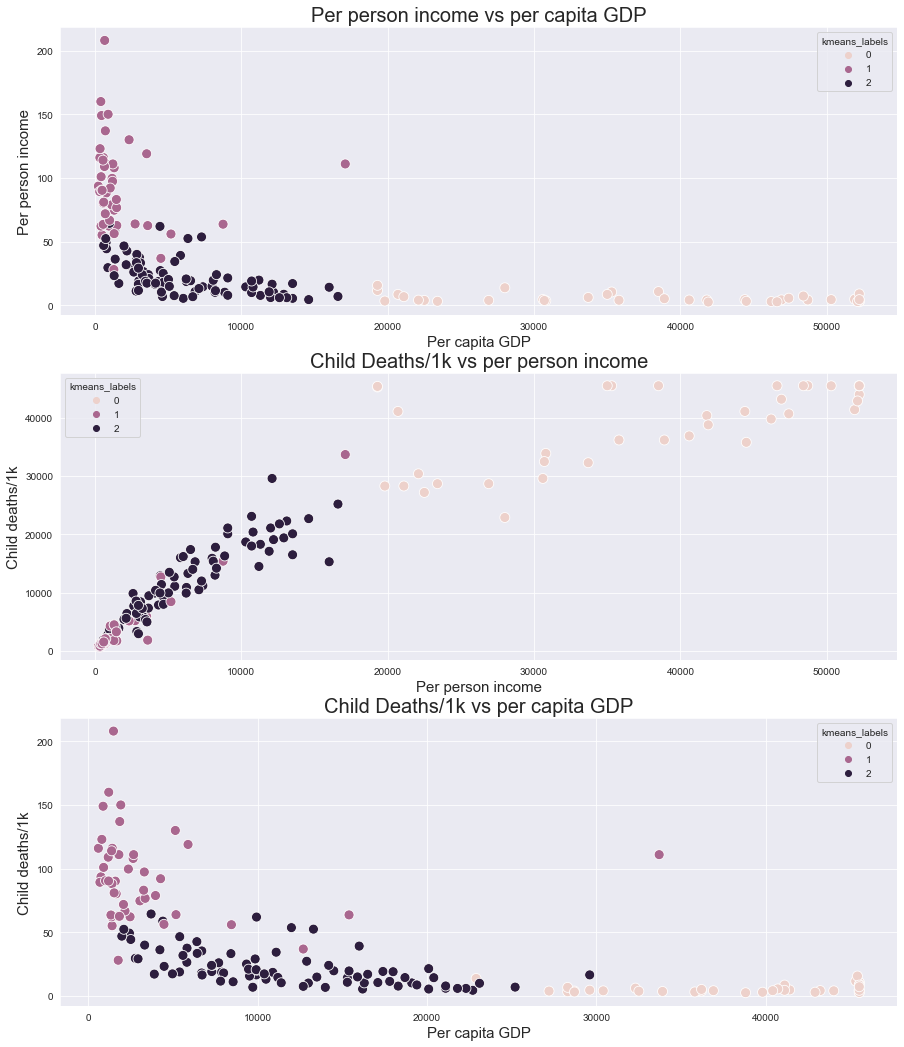

In [22]:
visualize_scatter('kmeans_labels')

### From the scatter plots, we can see that using 3 clusters, we will be able to accurately cluster the data. Let us try using hierarchical clustering and then finalize the number of clusters based on dendrogram.

# Single Linkage Hierarchical Clustering

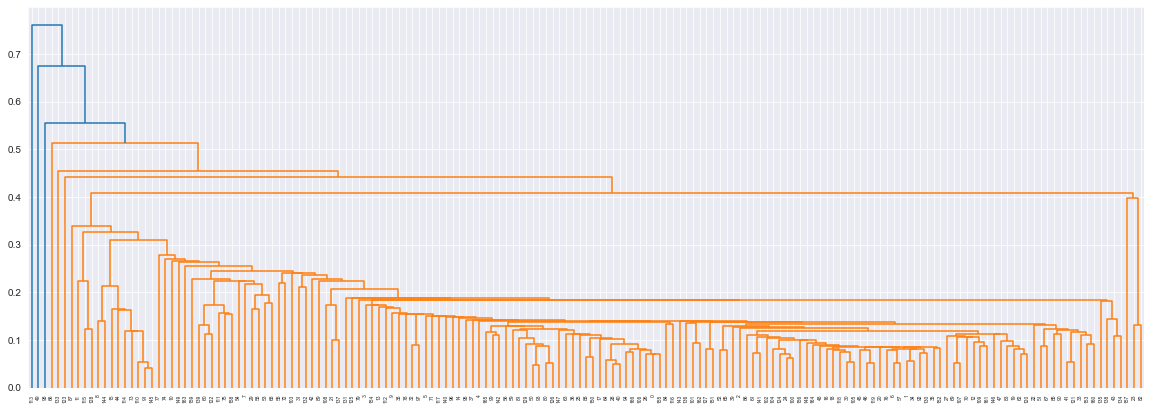

In [23]:
plt.figure(figsize = (20, 7))
mergings_sngl = linkage(num_df, method = 'single', metric = 'euclidean')
dendrogram(mergings_sngl)
plt.show()

### Cutting the dendrogram at n_clusters = 3 since that's what we got using kmeans algorithm.

In [24]:
cluster_lbl_sng = cut_tree(mergings_sngl, n_clusters = 3).reshape(-1, )
ctr_df['hierarchical_single_labels'] = cluster_lbl_sng
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels,hierarchical_single_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,0


## Visualizing clusters formed

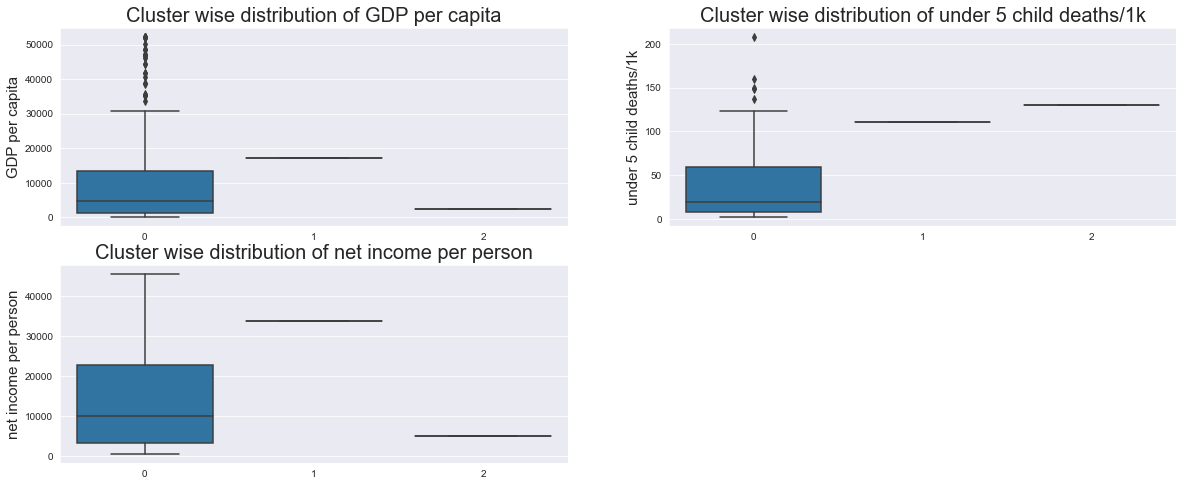

In [25]:
visualize_boxplot('hierarchical_single_labels')

### From the above plots, we can conclude that clusters formed are vague and there is no clear distiction in the boxplots among the clusters. Let us try with complete linkage.

# Complete Linkage Hierarchical Clustering

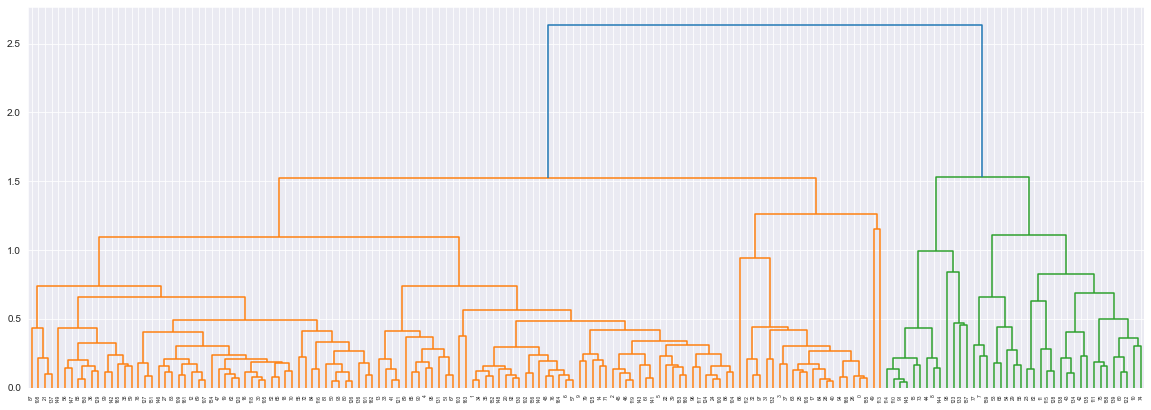

In [26]:
plt.figure(figsize = (20, 7))
mergings_cmp = linkage(num_df, method = 'complete', metric = 'euclidean')
dendrogram(mergings_cmp)
plt.show()

In [27]:
cluster_lbl_cmp = cut_tree(mergings_cmp, n_clusters = 3).reshape(-1, )
ctr_df['hierarchical_complete_labels'] = cluster_lbl_cmp
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels,hierarchical_single_labels,hierarchical_complete_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,0,0


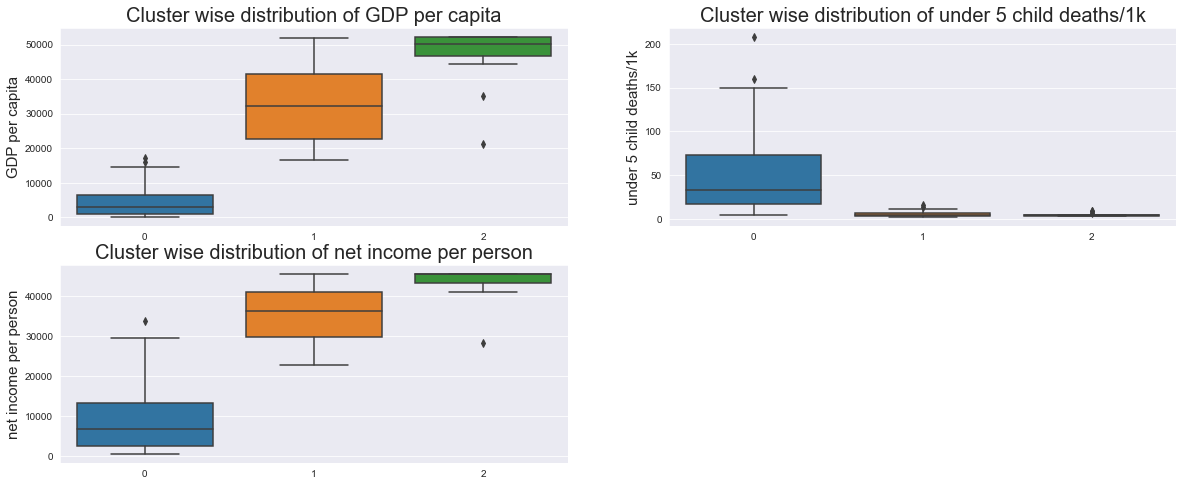

In [28]:
visualize_boxplot('hierarchical_complete_labels')

### From the above dendrogram and the box plots, let us try cutting the dendrogram at k = 4 and visualize if there is more distinction among the clusters.

In [29]:
cluster_lbl_f = cut_tree(mergings_cmp, n_clusters = 4).reshape(-1, )
ctr_df['hierarchical_complete_labels'] = cluster_lbl_f
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels,hierarchical_single_labels,hierarchical_complete_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,0,1


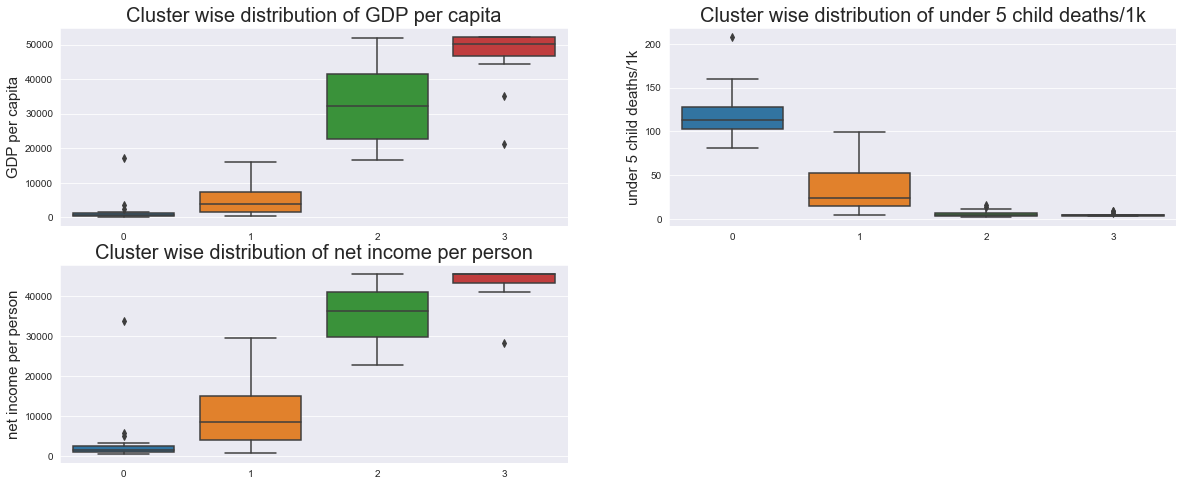

In [30]:
visualize_boxplot('hierarchical_complete_labels')

### From the above plots, we are confident that 4 cluster centers will be able to perfectly cluster our data. The following inferences can be made.
 - Countries belonging to cluster 3 are the developed countries. They have high imports, high exports, high income per person, low children born to women, high average newborn age, high GDP per capita and low child deaths/1k.
 - Countries belonging to cluster 0 are under-developed nations. They have high children born to women, low average newborn age, low income per person, low GDP per capita and high child deaths/1k.

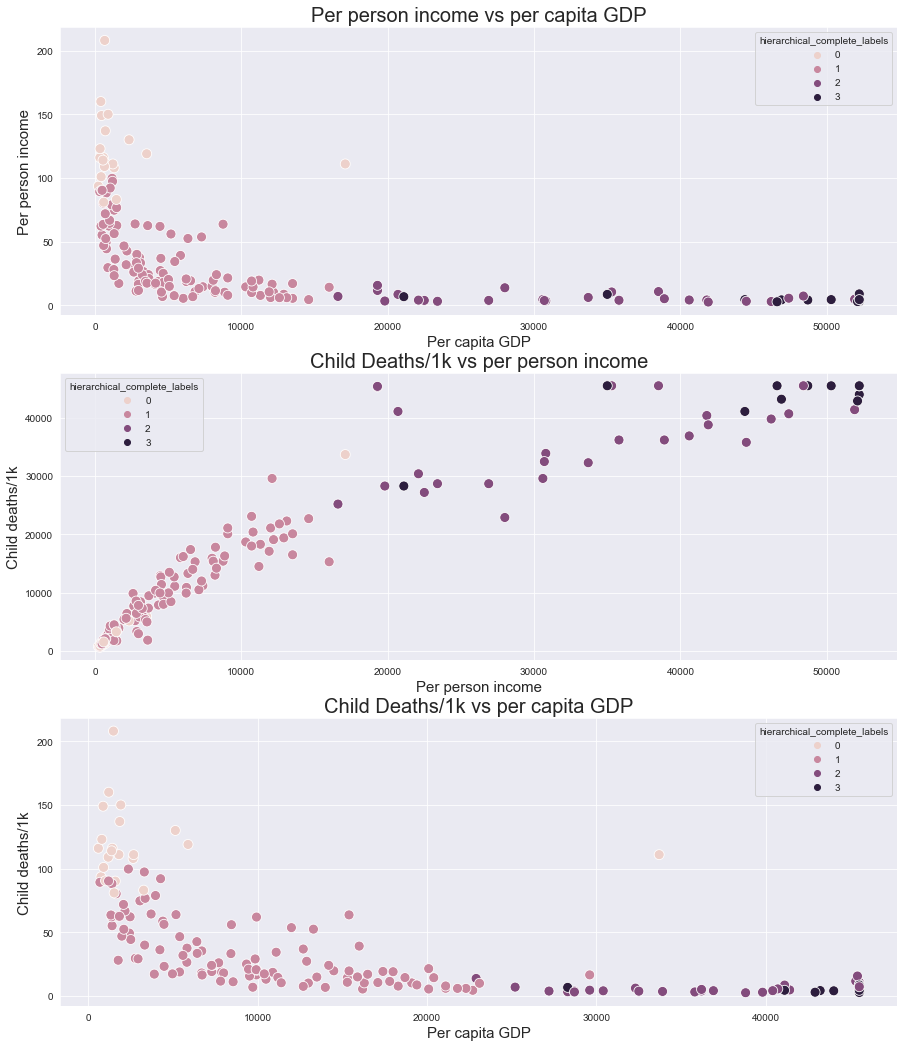

In [31]:
visualize_scatter('hierarchical_complete_labels')

### The scatter plots are also able to indentify the clusters decently.

### Now let us rebuild using KMeans and initialize the cluster centers with the values returned by Hierarchical Clustering - Complete Linkage and confirm that 4 clusters are the correct choice.

In [32]:
num_df['hierarchical_complete_labels'] = cluster_lbl_f
num_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hierarchical_complete_labels
0,0.426485,0.001491,0.005873,0.008940,0.022294,0.126144,0.475345,0.736593,0.006194,0
1,0.068160,0.031461,0.051490,0.071735,0.207599,0.080399,0.871795,0.078864,0.074230,1
2,0.120253,0.047064,0.034955,0.050533,0.273748,0.187691,0.875740,0.274448,0.081347,1
3,0.566699,0.060443,0.017720,0.054646,0.117842,0.245911,0.552268,0.790221,0.063458,0
4,0.037488,0.152611,0.145914,0.259388,0.411835,0.052213,0.881657,0.154574,0.230231,1


In [33]:
group_df = num_df.groupby(['hierarchical_complete_labels']).mean()
c0_centroid = group_df.loc[0].tolist()
c1_centroid = group_df.loc[1].tolist()
c2_centroid = group_df.loc[2].tolist()
c3_centroid = group_df.loc[3].tolist()

In [34]:
cluster_centers = np.array((c0_centroid, c1_centroid, c2_centroid, c3_centroid))

In [35]:
# Finalizing k = 4
kmeans_4 = KMeans(n_clusters = 4, max_iter = 50, init = cluster_centers, random_state = 100)
num_df = num_df.drop(columns = ['hierarchical_complete_labels'], axis = 1)
kmeans_4.fit(num_df)

ctr_df['kmeans_labels'] = kmeans_4.labels_
ctr_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels,hierarchical_single_labels,hierarchical_complete_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1,0,1


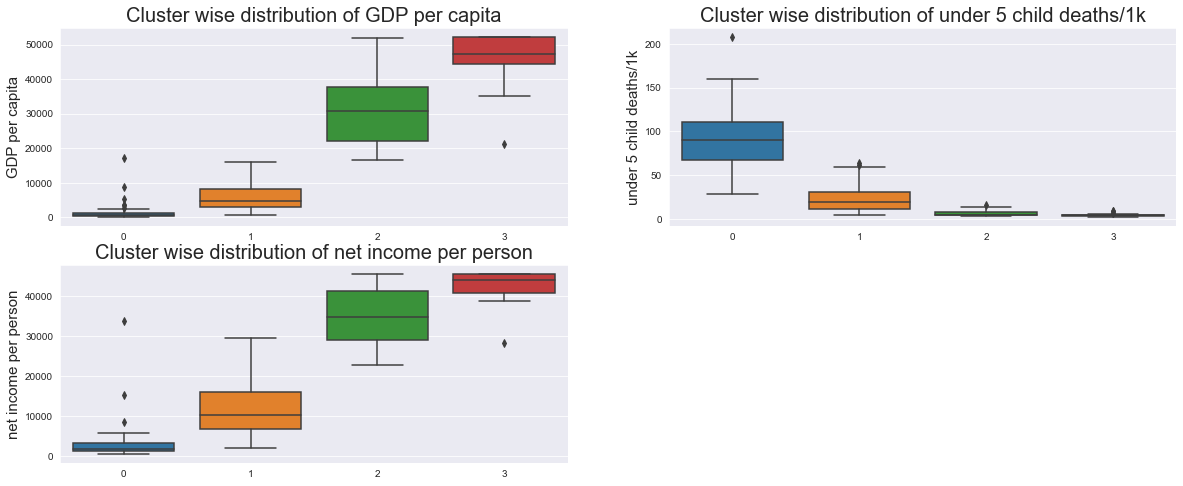

In [36]:
visualize_boxplot('kmeans_labels')

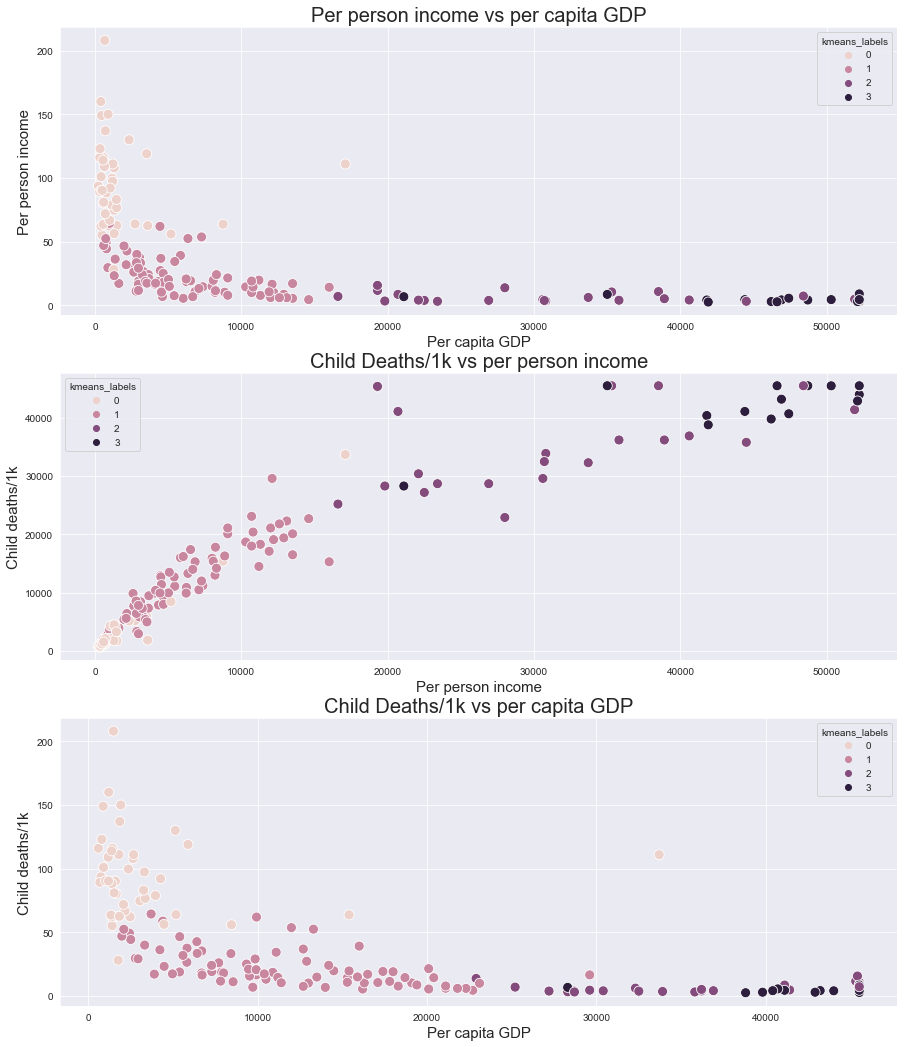

In [37]:
visualize_scatter('kmeans_labels')

### We can finalize k = 4 as the boxplots and the scatterplots show clear distinction.

### Observations:
   - From both KMeans and Hierarchical Clustering, countries belonging to cluster 0 are poor, they have high child deaths/1k, low net income per person and low GDP.

# Under-developed countries (Hierarchical Clustering)

In [38]:
cluster_0_df = ctr_df[ctr_df.hierarchical_complete_labels == 0]
cluster_0_df = cluster_0_df.drop(columns = ['kmeans_labels', 'hierarchical_single_labels'], axis = 1)
cluster_0_df.country.values

array(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Congo, Dem. Rep.',
       "Cote d'Ivoire", 'Equatorial Guinea', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Malawi', 'Mali', 'Mozambique', 'Niger', 'Nigeria',
       'Sierra Leone', 'Uganda', 'Zambia'], dtype=object)

In [39]:
cluster_0_df.sort_values(by = ['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hierarchical_complete_labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0


# Under-developed countries (KMeans Clustering)

In [40]:
cluster_0_df = ctr_df[ctr_df.kmeans_labels == 0]
cluster_0_df = cluster_0_df.drop(columns = ['hierarchical_single_labels', 'hierarchical_complete_labels'], axis = 1)
cluster_0_df.country.values

array(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire",
       'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Lao',
       'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda',
       'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tanzania',
       'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'], dtype=object)

In [41]:
cluster_0_df.sort_values(by = ['gdpp', 'income', 'child_mort'], ascending = [True, True, False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0


### The CEO of HELP International should focus on Burundi, Liberia, Republic of Congo, Niger, Sierra Leone and Mozambique (the above displayed countries, based on both KMeans and Hierarchical Clustering) at the earliest since they have extremely poor conditions, that is low GDP per capita, low income per person and high child deaths/1k.